In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup codes

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  
device = torch.device('cuda:0')

Good to go!


In [4]:
np.set_printoptions(linewidth=np.inf)

pcp = ['A(bass)', 'Bb(bass)', 'B(bass)', 'C(bass)', 'C#(bass)', 'D(bass)', 'Eb(bass)', 'E(bass)', 'F(bass)', 'F#(bass)', 'G(bass)', 'Ab(bass)', 'A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab']

chord2index = {'N': 0, 'B#:maj': 1, 'C:maj': 1, 'C#:maj': 2, 'Db:maj': 2, 'D:maj': 3, 'D#:maj': 4, 'Eb:maj': 4, 'E:maj': 5, 'Fb:maj': 5, 'E#:maj': 6, 'F:maj': 6, 'F#:maj': 7, 'Gb:maj': 7, 'G:maj': 8, 'G#:maj': 9, 'Ab:maj': 9, 'A:maj': 10, 'A#:maj': 11, 'Bb:maj': 11, 'B:maj': 12, 'Cb:maj': 12, 'B#:min': 13, 'C:min': 13, 'C#:min': 14, 'Db:min': 14, 'D:min': 15, 'D#:min': 16, 'Eb:min': 16, 'E:min': 17, 'Fb:min': 17, 'E#:min': 18, 'F:min': 18, 'F#:min': 19, 'Gb:min': 19, 'G:min': 20, 'G#:min': 21, 'Ab:min': 21, 'A:min': 22, 'A#:min': 23, 'Bb:min': 23, 'B:min': 24, 'Cb:min': 24, 'X': 25}
index2chord = {0: 'N', 1: 'C:maj', 2: 'C#:maj', 3: 'D:maj', 4: 'Eb:maj', 5: 'E:maj', 6: 'F:maj', 7: 'F#:maj', 8: 'G:maj', 9: 'Ab:maj', 10: 'A:maj', 11: 'Bb:maj', 12: 'B:maj', 13: 'C:min', 14: 'C#:min', 15: 'D:min', 16: 'Eb:min', 17: 'E:min', 18: 'F:min', 19: 'F#:min', 20: 'G:min', 21: 'Ab:min', 22: 'A:min', 23: 'Bb:min', 24: 'B:min', 25: 'X'}

num_chords = len(index2chord)

chroma_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-chordino/'
chord_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-mirex/'

files = os.listdir(chroma_path)

batch_size = 64
print_every = 50
num_pcp = len(pcp)

def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

seed(1)

In [97]:
checkpoint = torch.load('/content/drive/MyDrive/ML Project/data/all.tar')

# General data
file_infos = checkpoint['file_infos']
train_files = checkpoint['train_files']
validation_files = checkpoint['validation_files']
test_files = checkpoint['test_files']

# Task 1: MLP data
train_chroma_samples = checkpoint['train_chroma_samples']
train_chord_labels = checkpoint['train_chord_labels']
validation_chroma_samples = checkpoint['validation_chroma_samples']
validation_chord_labels = checkpoint['validation_chord_labels']
test_chroma_samples = checkpoint['test_chroma_samples']
test_chord_labels = checkpoint['test_chord_labels']
splitted_train_data = checkpoint['splitted_train_data']

# Task 1: Viterbi data
transition_matrix = checkpoint['transition_matrix']

# Task 2: LSTM data
train_chord_sequences = checkpoint['train_chord_sequences'] 
validation_chord_sequences = checkpoint['validation_chord_sequences']
test_chord_sequences = checkpoint['test_chord_sequences']

# Chord_Generator Building & Training

In [86]:
seq_length = 200
embedding_dim = 100
hidden_size = 128
num_layers = 2 # maximum 5
bidirectional = False

In [7]:
def make_dataset(chord_sequences, seq_length, batch_size, shuffle = True, device = device):
  dataset_list = []
  for song in chord_sequences:
    num_seq = len(song) // (seq_length + 1)
    for i in range(num_seq):
      dataset_list.append(song[i*(seq_length+1):(i+1)*(seq_length+1)])
  dataset_tensor = torch.tensor(dataset_list, dtype = torch.int64, device = device)
  dataset = torch.utils.data.TensorDataset(dataset_tensor[:, :-1], dataset_tensor[:, 1:])
  loader = DataLoader(dataset, batch_size=batch_size, shuffle = shuffle)
  return loader

In [8]:
train_loader = make_dataset(train_chord_sequences, seq_length, batch_size, shuffle = True, device = device)
validation_loader = make_dataset(validation_chord_sequences, seq_length, batch_size, shuffle = False, device = device)
test_loader = make_dataset(test_chord_sequences, seq_length, batch_size, shuffle = False, device = device)

In [85]:
class Chord_Generator_LSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_size, num_layers, bidirectional):
    super(Chord_Generator_LSTM, self).__init__()

    D = 2 if bidirectional else 1
    self.D = D
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(num_chords, embedding_dim)
    self.LSTM = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
    self.output_emb = nn.Linear(D * hidden_size, num_chords)
  
  def forward(self, sources):
    N = sources.shape[0]
    h = sources.new_zeros(self.D * self.num_layers, N, self.hidden_size).float()
    c = sources.new_zeros(self.D * self.num_layers, N, self.hidden_size).float()
    chord_embedded = self.embedding(sources)
    outputs, _ = self.LSTM(chord_embedded, (h, c))
    pred = self.output_emb(outputs)
    return pred
  
  def generate_chords(self, start_chords, num_generate, temperature, random_prediction = True):
    input = torch.tensor(start_chords, dtype=torch.int64, device=device)
    h = input.new_zeros(self.D * self.num_layers, 1, self.hidden_size).float()
    c = input.new_zeros(self.D * self.num_layers, 1, self.hidden_size).float()

    with torch.no_grad():
      chord_embedded = self.embedding(input.unsqueeze(0))
      o, (h, c) = self.LSTM(chord_embedded, (h, c))
      pred = self.output_emb(o)[0, -1, :]
      pred = pred / temperature
      if random_prediction:
        m = torch.distributions.Categorical(logits = pred)
        pred_chord = m.sample()
      else:
        pred_chord = pred.argmax()
      input = pred_chord.unsqueeze(0)
      chords_generated = [pred_chord.item()]

      for i in range(num_generate - 1):
        chord_embedded = self.embedding(input.unsqueeze(0))
        o, (h, c) = self.LSTM(chord_embedded, (h, c))
        pred = self.output_emb(o)[0, -1, :]
        pred = pred / temperature
        if random_prediction:
          m = torch.distributions.Categorical(logits = pred)
          pred_chord = m.sample()
        else:
          pred_chord = pred.argmax()
        input = pred_chord.unsqueeze(0)
        chords_generated.append(pred_chord.item())

      return chords_generated

In [80]:
def check_accuracy_LSTM(model, loader):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      scores = model(x)
      preds = scores.argmax(-1)
      targets = y
      num_correct += (preds == targets).sum()
      num_samples += preds.size(0) * preds.size(1)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), end = ' ')
  return acc

In [81]:
def train_LSTM(model, train_loader, optimizer, validation_loader=None, epochs=1):
    model = model.to(device=device)
    acc = 0
    for e in range(epochs):
        print('Epoch {}/{} ===================================================================================================================================='.format(e+1, epochs))
        for t, (x, y) in enumerate(train_loader):
            model.train()

            scores = model(x).softmax(dim=-1)

            loss = F.cross_entropy(scores, torch.eye(num_chords, device = device)[y])

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                if validation_loader:
                  acc = check_accuracy_LSTM(model, validation_loader)
                print()
    return acc

In [87]:
learning_rate = 1e-3
weight_decay = 1e-4
epochs = 1

Chord_Generator = Chord_Generator_LSTM(embedding_dim, hidden_size, num_layers, bidirectional)
optimizer = optim.Adam(Chord_Generator.parameters(), lr=learning_rate, weight_decay = weight_decay)
train_LSTM(Chord_Generator, train_loader, optimizer, validation_loader=validation_loader, epochs=epochs)

Epoch 1/1 ====================================================================================================================================
Iteration 0, loss = 40.7557
Got 50613 / 251000 correct (20.16) 
Iteration 50, loss = 38.2297
Got 220281 / 251000 correct (87.76) 
Iteration 100, loss = 37.7558
Got 245212 / 251000 correct (97.69) 
Iteration 150, loss = 37.6892
Got 246318 / 251000 correct (98.13) 


0.9813466135458168

# Load the model

In [95]:
def get_chroma_chord_data(file):
  chroma_tensors = []
  chord_tensors = []

  chroma_data = open(chroma_path + file + '/bothchroma.csv', 'r')
  chord_data = open(chord_path + file + '/majmin.lab', 'r')

  chord_line = chord_data.readline()

  start_end_chord = chord_line.split()
  end = float(start_end_chord[1])
  for chroma_line in chroma_data:
    time_chroma = chroma_line.split(',')
    t = float(time_chroma[1])
    if t > end:
      chord_line = chord_data.readline()
      if not chord_line: break
      start_end_chord = chord_line.split()
      if len(start_end_chord) < 3: break
      end = float(start_end_chord[1])

    chroma = time_chroma[2:]
    chroma[-1] = chroma[-1][:-1]
    chroma = list(map(float, chroma))
    chord = start_end_chord[2]
    chroma_tensors.append(torch.tensor(chroma, dtype = torch.float32, device = device))
    chord_tensors.append(torch.tensor([chord2index[chord]], dtype = torch.int64, device = device))

  chroma_data.close()
  chord_data.close()

  chroma_samples = torch.stack(chroma_tensors, dim=0)
  chord_labels = F.one_hot(torch.cat(chord_tensors, dim=0), num_classes=num_chords)
  return chroma_samples, chord_labels

In [98]:
checkpoint_MLP = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver5.tar')
model = checkpoint_MLP['model'].to(device=device)

In [96]:
def Chord_Extractor_Viterbi(P0):
  len_song = P0.shape[0]

  delta = torch.zeros(len_song, num_chords, device=device)
  psi = torch.zeros(len_song, num_chords, device=device)
  
  delta[0, :] = (1/num_pcp) * P0[0, :]
  for t in range(1, len_song):
    delta[t, :], _ =torch.max(delta[t-1:t, :] * transition_matrix.T * P0[t:t+1, :].T, dim=1)
    psi[t, :] = torch.argmax(delta[t-1:t, :] * transition_matrix.T, dim=1)
    max_del, _ = torch.max(delta[t, :], dim=0)
    while max_del.item() < 0.01:
      delta[t, :] *= 10
      max_del, _ = torch.max(delta[t, :], dim=0)

  processed = torch.zeros(len_song, dtype=torch.int64, device=device)
  processed[len_song-1] = torch.argmax(delta[len_song-1, :])
  for t in range(len_song - 1, 0, -1):
    processed[t - 1] = psi[t, processed[t]]
  return processed

In [99]:
def Chord_Extractor_CCS(chroma_samples, preds_0, threshold = 1.0):
  preds = preds_0.clone()
  
  file_length = preds.shape[0]
  for i in range(1, file_length):
    if preds[i] != preds[i-1] and torch.dist(chroma_samples[i], chroma_samples[i - 1]).item() > threshold:
      preds[i] = preds[i-1]
  
  return preds

In [100]:
def Chord_Extractor(file):
  model.eval()
  with torch.no_grad():
    chroma_samples, targets = get_chroma_chord_data(file)
    P0 = model(chroma_samples)
    preds_0 = Chord_Extractor_Viterbi(P0)
    preds = Chord_Extractor_CCS(chroma_samples, preds_0)
    return preds

# Plot

In [101]:
import matplotlib.pyplot as plt

def plot_generated_chords(start_chords, predicted_chords, original_chords):
  delta_t = 2048/44100
  length1 = len(start_chords)
  length2 = len(predicted_chords)
  X = np.arange(length1 + length2) * delta_t
  X1 = np.arange(length1) * delta_t
  X2 = np.arange(length1, length1 + length2) * delta_t
  
  fig = plt.figure(figsize=(20, 8))
  plt.scatter(X, original_chords, c='#ffc0cb', s=130, marker = 's', label = 'Original Chords')
  plt.scatter(X1, start_chords, c='#3ec5f1', marker = 's', label = 'Given Chords')
  plt.scatter(X2, predicted_chords, c='#80d038', marker = 's', label = 'Generated Chords')
  plt.yticks(np.arange(num_chords), labels=index2chord.values())
  plt.grid(True, axis='both')
  plt.legend()
  plt.show()

In [20]:
def get_chord_sequence(file):
  delta_t = 2048/44100

  chord_data = open(chord_path + file + '/majmin.lab', 'r')
  chord_line = chord_data.readline()

  start_end_chord = chord_line.split()
  end = float(start_end_chord[1])
  t = 0
  song = []
  while True:
    t += delta_t
    if t > end:
      chord_line = chord_data.readline()
      if not chord_line: break
      start_end_chord = chord_line.split()
      if len(start_end_chord) < 3: break
      end = float(start_end_chord[1])

    chord = start_end_chord[2]
    song.append(chord2index[chord])

  chord_data.close()
  return song

In [102]:
chord_sequence = get_chord_sequence('1007')
file_length = len(chord_sequence)
cut = file_length // 2
start_chords = chord_sequence[:cut]
original_chords = chord_sequence

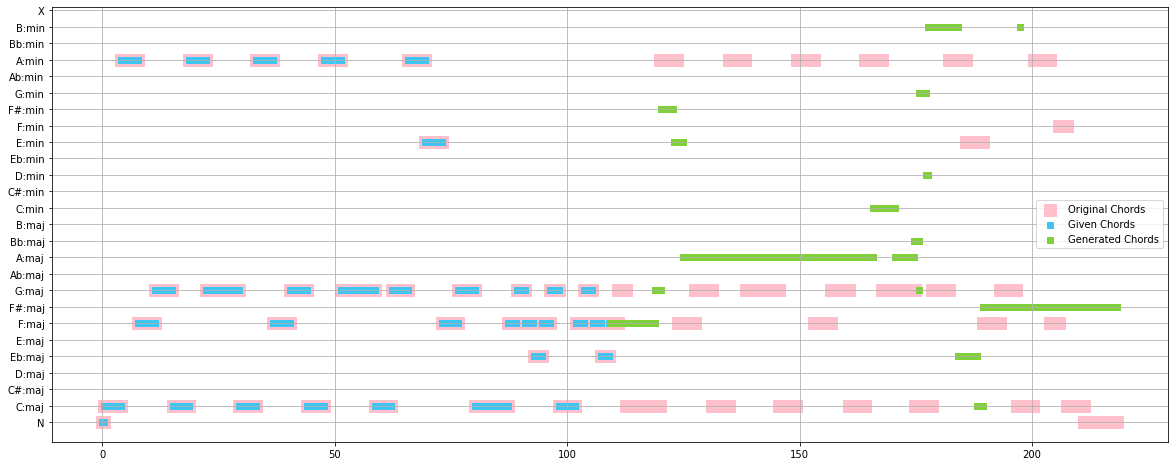

In [89]:
predicted_chords = Chord_Generator.generate_chords(start_chords=start_chords, num_generate=file_length-cut, temperature=1.0, random_prediction = True)
plot_generated_chords(start_chords, predicted_chords, original_chords)

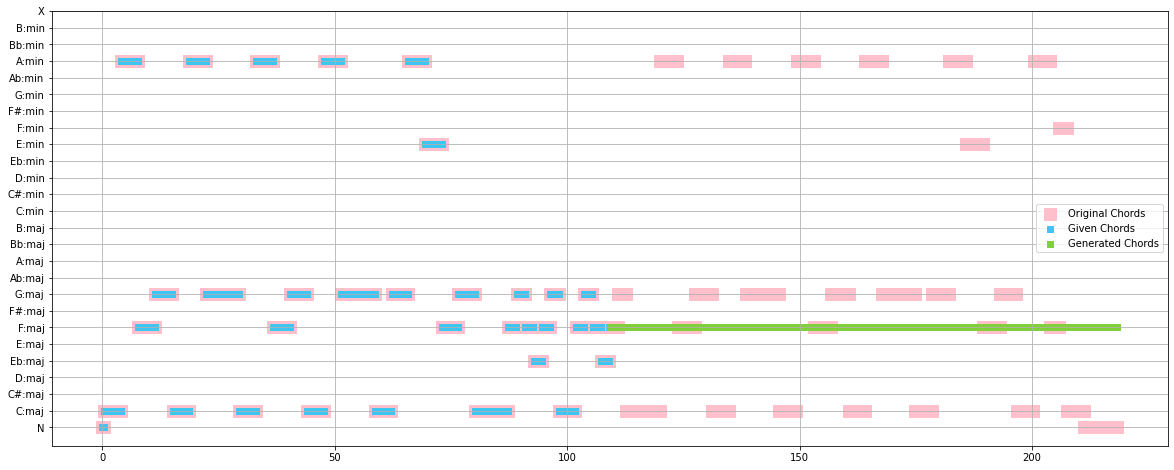

In [103]:
predicted_chords = Chord_Generator.generate_chords(start_chords=start_chords, num_generate=file_length-cut, temperature=1.0, random_prediction = False)
plot_generated_chords(start_chords, predicted_chords, original_chords)

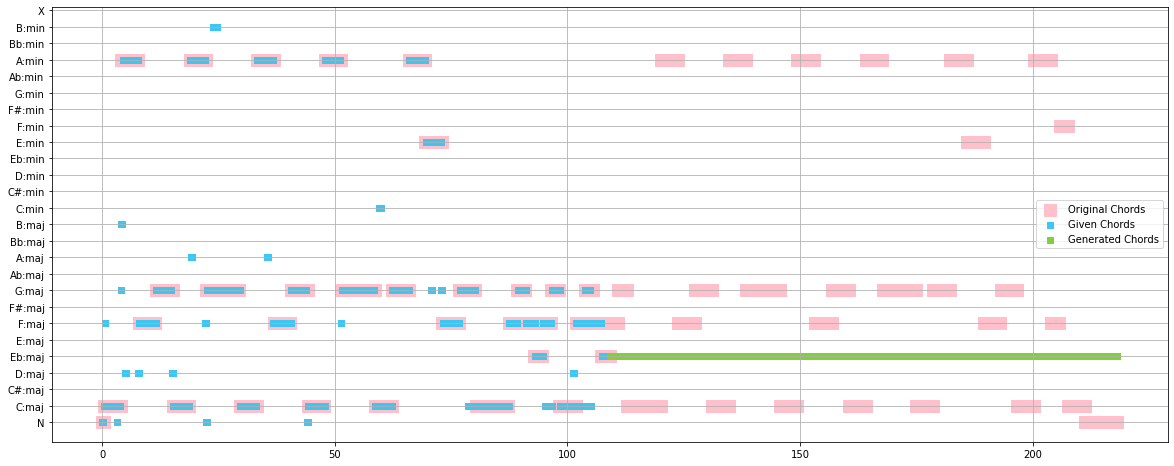

In [107]:
chroma_samples, chord_labels = get_chroma_chord_data('1007')
file_length = chord_labels.shape[0]
cut = file_length//2
start_chords = Chord_Extractor('1007')[:cut].cpu().numpy()
original_chords = chord_labels.argmax(1).cpu()
predicted_chords = Chord_Generator.generate_chords(start_chords=start_chords, num_generate=file_length-cut, temperature=1.0, random_prediction = False)
plot_generated_chords(start_chords, predicted_chords, original_chords)

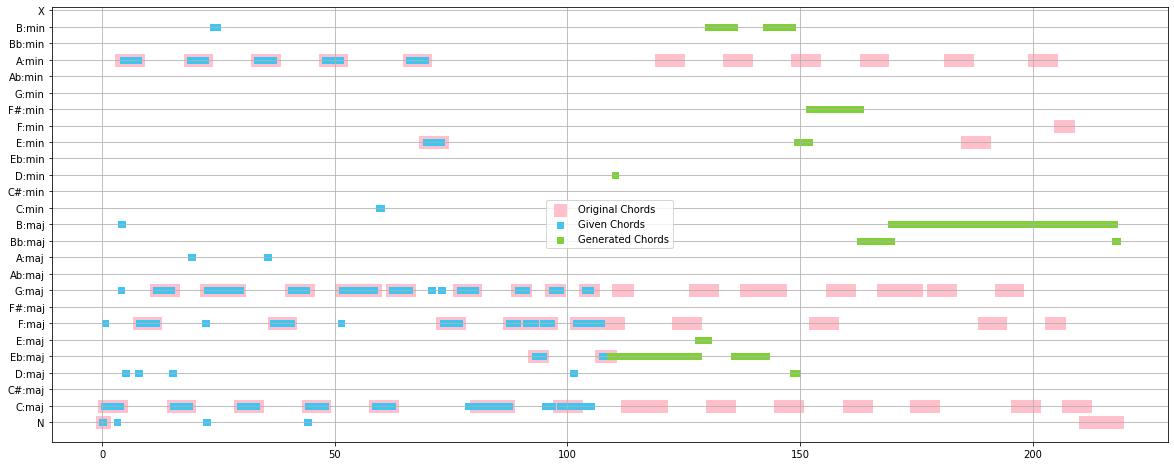

In [114]:
predicted_chords = Chord_Generator.generate_chords(start_chords=start_chords, num_generate=file_length-cut, temperature=1.0, random_prediction = True)
plot_generated_chords(start_chords, predicted_chords, original_chords)

# Chord Player

In [34]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
def get_chords_time(chord_sequence, bar_time):

  # Count the chords
  chords_count = []
  last = [-1, 0]
  for chord in chord_sequence:
    if chord == last[0]:
      last[1] += 1
    else:
      chords_count.append(last)
      last = [chord, 1]
  chords_count.append(last)
  chords_count = chords_count[1:]

  # Change the count into time (ms)
  for i in range(len(chords_count)):
    chords_count[i][1] = int(chords_count[i][1] * 20480 / 441) // bar_time * bar_time
  
  while chords_count:
    while chords_count[0][1]:
      yield(chords_count[0][0], 500)
      chords_count[0][1] -= 500
    chords_count = chords_count[1:]

In [36]:
from pydub import AudioSegment

chord_files_path = '/content/drive/MyDrive/ML Project/chord_files/'
audio_files = [None]
for i in range(1, 25):
  audio_files.append(AudioSegment.from_file(chord_files_path + str(i) + '.wav', format="wav"))

In [90]:
output = AudioSegment.empty()

for chord, time in get_chords_time(start_chords + predicted_chords, 500):
  if chord in range(1, 25):
    output += audio_files[chord][:time]
  else:
    output += AudioSegment.silent(duration=time)

file_handle = output.export("/content/drive/MyDrive/ML Project/output.mp3", format="mp3")

In [92]:
output

In [119]:
result = output[110000:120000].export("/content/drive/MyDrive/ML Project/result.mp3", format="mp3")